## Fantasy Football Draft Tier Clustering Process
### Conceptual Overview
- This script performs advanced clustering and ranking of fantasy football players based on their performance metrics.
- Information in this cell describes the process of clustering fantasy football players into draft tiers using Gaussian Mixture Models (GMM). 
- Approach involves feature engineering, dimensionality reduction, clustering, and tier assignment to provide valuable insights for draft strategies.
---

### One-Hot Encoding of Positions
- Converts categorical `position` column into numerical one-hot encoded features (i.e. `pos_QB`, `pos_RB`).
- Ensures positions contribute to clustering rather than being treated as a label.
- Allows **positional impact** to be considered in clustering.
- Helps separate **RBs, WRs, TEs, and QBs** effectively.

### Preparing Data for Clustering
- **Standardize Features**
   - Uses `StandardScaler()` to normalize all numerical features.
   - Ensures fair weighting across different statistics (e.g., yards, touchdowns, points).
- **Dimensionality Reduction with PCA**
   - Uses **Principal Component Analysis (PCA)** to reduce high-dimensional data.
   - Keeps **90% of variance** to balance information retention and noise reduction.
- Reduces data complexity while preserving **key performance trends**.
- Helps GMM focus on the most **important player attributes**.

### Finding the Optimal Number of Clusters
- Tests **multiple cluster counts** (6 to 20) to find the best grouping.
- Uses **Bayesian Information Criterion (BIC)** and **Akaike Information Criterion (AIC)** to select the most efficient clustering structure.
- Determines **how many unique player groups** exist based on their stats.
- Prevents **overfitting or underfitting** by using an optimal number of clusters.

### Clustering Players with Gaussian Mixture Model (GMM)
- **Train GMM with optimal clusters**.
- **Assign each player to a cluster** based on statistical similarity.
- **Evaluate clustering quality** using:
   - **Silhouette Score** (closer to **1** is better)
   - **Davies-Bouldin Score** (lower is better)
- Groups players into **performance-based tiers** rather than relying on ADP.
- Identifies hidden patterns, such as **consistent mid-tier performers** vs. **boom-or-bust players**.

### Analyzing Position Distribution Across Clusters
- **Computes the proportion of positions within each cluster**.
- **Visualizes cluster composition** using a heatmap and bar chart.
- Highlights which positions **dominate certain clusters**.
- Helps determine whether **QBs, RBs, WRs, or TEs** are overrepresented in specific player groups.

### PCA Feature Importance Analysis
- Extracts **PCA loadings**, which measure how much each feature contributes to the principal components.
- Displays a **heatmap** of feature importance.
- Helps **identify the most critical stats** for player evaluation.
- Can reveal whether **consistency, touchdowns, or volume** drive fantasy success.
 
### Assign Players to Draft Tiers
- **Computes a performance score** based on all numerical stats.
- **Adjusts rankings based on position weights**:
   - **RBs & WRs (1.2x weight)** (Higher priority due to scarcity)
   - **TEs (1.0x weight)** (No boost)
   - **QBs (0.8x weight)** (Reduced priority due to depth)
- **Ranks players based on adjusted score**.
- **Splits players into 16 draft tiers using quantile-based binning**.
- Provides a **positionally balanced draft board**.
- Helps fantasy managers prioritize **high-value players** over ADP biases.
---

### Summary
- This process transforms **raw fantasy football stats** into **actionable draft tiers** using:
- **Machine learning clustering (GMM)** to group similar players.
- **PCA-based feature selection** to enhance model performance.
- **Position-aware tiering** to balance player value.
- Allows for **further analysis** and **custom draft strategies**.
- Can be **integrated into fantasy draft tools** or **rankings sheets**.
- **Result:** A **data-driven draft strategy** that improves player selection over traditional ADP-based rankings.

---

In [2]:
#############################################
### Import Libraries
#############################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

## set pandas display options
pd.set_option('display.max_rows', None)          ## remove row display limit
pd.set_option('display.max_columns', None)       ## remove column display limit
pd.set_option('display.max_colwidth', None)      ## ensure full dataframe content is shown
pd.set_option('display.width', 0)                ## prevent truncated dataframe output

In [3]:
#############################################
### Load & Preview Data
#############################################

## load clean 2024 weekly NFL fantasy football stats
gmm_df = pd.read_csv("./data/GMM_player_stats.csv")
gmm_df.head()

,player_id,player_name,position,ppg,fantasy_stdev,projected_ppg,last_3_avg,boom_weeks,bust_weeks,low_floor_weeks,momentum,availability_score,weekly_consistency_score,efficiency_ratio
0,8439,Aaron Rodgers,QB,13.624706,7.537724,14.798824,13.072549,3.0,2.0,1.0,0.806667,1.000000,1.807536,0.920661
1,14880,Kirk Cousins,QB,10.371765,9.658592,13.316471,11.571176,2.0,7.0,4.0,-20.390000,1.000000,1.073838,0.778867
2,14881,Russell Wilson,QB,15.322500,6.305766,15.420000,13.764167,1.0,2.0,1.0,12.466667,0.470588,2.429919,0.993677
3,15795,DeAndre Hopkins,WR,8.647059,7.442288,9.684706,8.938235,1.0,7.0,4.0,-4.950000,1.000000,1.161882,0.892857
4,15807,Cordarrelle Patterson,RB,2.050000,4.100000,2.127500,5.341667,0.0,3.0,2.0,-13.166667,0.235294,0.500000,0.963572


In [4]:
#############################################
## One-Hot Encoding of Positions
#############################################

## convert position to one-hot encoded columns
gmm_df = pd.get_dummies(gmm_df, columns=['position'], prefix="pos")

## select only numeric columns, excluding player_id
features = gmm_df.select_dtypes(include=["number"]).columns.tolist()
features = [col for col in features if col not in ["player_id"]]

In [5]:
#############################################
## Prepare Clusters with Scaling & PCA
#############################################

## scale numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gmm_df[features])

## apply PCA with dynamic component selection, retaining 90% of variance explained
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

In [6]:
#############################################
## Determine Optimal Number of Clusters
#############################################

## determine optimal number of clusters for GMM using BIC & AIC
bic_scores, aic_scores = [], []
cluster_range = range(8, 20)

## iterate through cluster_range to find optimal clusters for GMM
for k in cluster_range:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

## select optimal number of clusters that minimizes BIC
optimal_clusters = cluster_range[bic_scores.index(min(bic_scores))]
print(f"Optimal Cluster Count (BIC): {optimal_clusters}")

Optimal Cluster Count (BIC): 8


In [7]:
#############################################
## Gaussian Mixture Model (GMM) for Clustering
#############################################

## fit optimal GMM
gmm = GaussianMixture(n_components=optimal_clusters, covariance_type="full", random_state=42)
gmm_df["cluster"] = gmm.fit_predict(X_pca)

## compute silhouette score and davies-bouldin score to evaluate cluster quality
silhouette_avg = silhouette_score(X_pca, gmm_df["cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f} (Closer to 1 is better)\n")
labels = gmm_df["cluster"]
db_score = davies_bouldin_score(X_pca, labels)
print(f"Davies-Bouldin Score: {db_score:.4f} (Lower is better)")

## summarize metrics for each cluster
cluster_summary = gmm_df.groupby("cluster")[features].mean()
print("Cluster Summary:\n", cluster_summary)

Silhouette Score: 0.1633 (Closer to 1 is better)

Davies-Bouldin Score: 1.3344 (Lower is better)
Cluster Summary:
                ppg  fantasy_stdev  projected_ppg  last_3_avg  boom_weeks  \
cluster                                                                    
0         8.713465       8.456932       9.274916   10.221992    1.461538   
1        12.530894       8.267855      12.280911   12.121390    2.916667   
2         2.413333       1.665291       8.320083    7.040500    0.200000   
3         4.975000       0.176777       7.032500    8.391667    0.000000   
4        18.740234       9.395067      17.519196   17.720027    6.950000   
5         3.140941       2.586864       4.921867    3.558498    0.050000   
6         8.078750       1.651896       9.165600    7.221125    0.000000   
7         6.694790       6.428640       7.303419    6.930986    0.653061   

         bust_weeks  low_floor_weeks   momentum  availability_score  \
cluster                                              

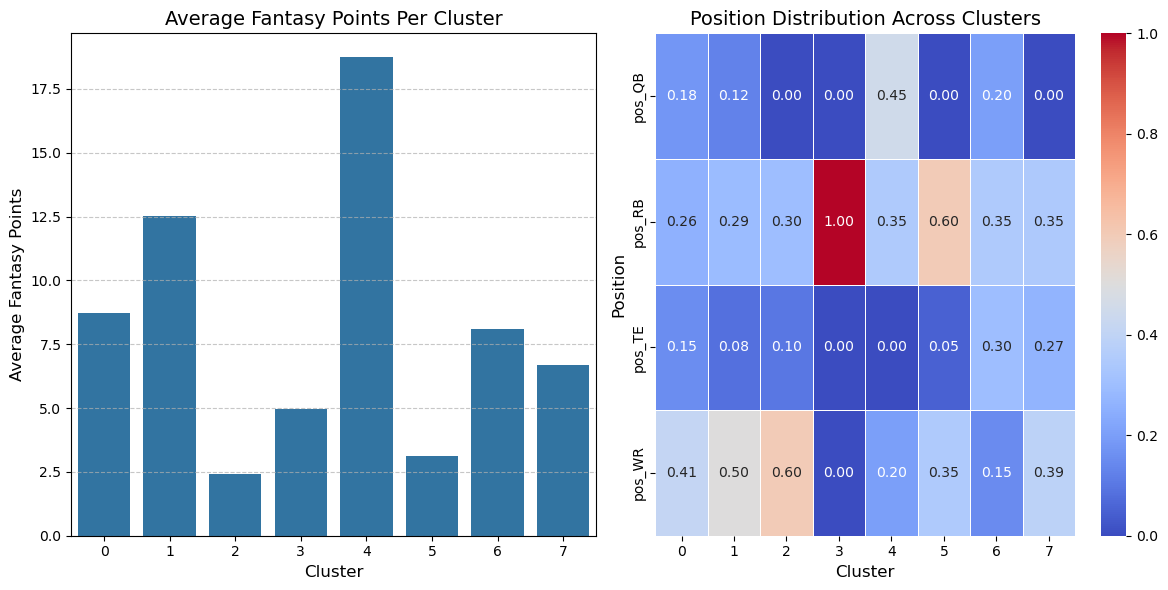

In [8]:
###################################################
## Analyze Position Distribution Across Clusters
###################################################

## store position columns as list
position_columns = [col for col in gmm_df.columns if col.startswith("pos_")]

## position distribution per cluster
position_distribution = gmm_df.groupby("cluster")[position_columns].sum()

## normalize position counts per cluster
position_distribution = position_distribution.div(position_distribution.sum(axis=1), axis=0).fillna(0)

## visualize position distribution across clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

## bar plot of average fantasy points per cluster
sns.barplot(x=cluster_summary.index, y=cluster_summary["ppg"], ax=axes[0])
axes[0].set_title("Average Fantasy Points Per Cluster", fontsize=14)
axes[0].set_xlabel("Cluster", fontsize=12)
axes[0].set_ylabel("Average Fantasy Points", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

## heatmap of position distribution per cluster
sns.heatmap(position_distribution.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Position Distribution Across Clusters", fontsize=14)
axes[1].set_xlabel("Cluster", fontsize=12)
axes[1].set_ylabel("Position", fontsize=12)

plt.tight_layout()
plt.show()

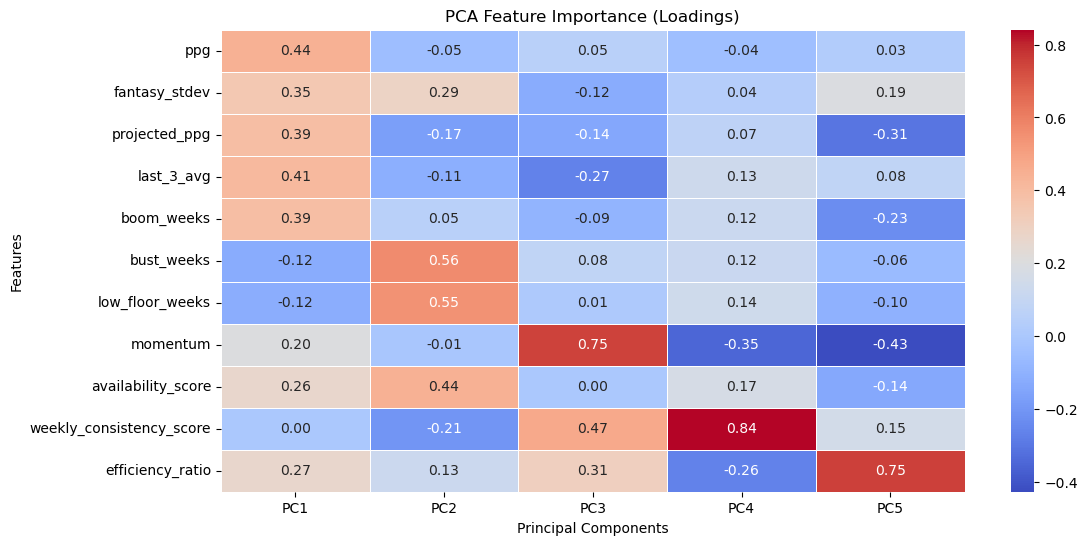

In [9]:
#############################################
## PCA Feature Importance Analysis
#############################################

## extract PCA loadings to inspect feature importance
pca_loadings = pd.DataFrame(pca.components_.T, index=features, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

## visualize PCA loadings
plt.figure(figsize=(12, 6))
sns.heatmap(pca_loadings, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("PCA Feature Importance (Loadings)")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()

In [10]:
#############################################
## Assign Player Draft Tiers
#############################################

## aggregate all metrics to compute overall performance score for each player
gmm_df["performance_score"] = gmm_df[features].mean(axis=1)

## define position weights for fantasy impact, where RB, WR, TE are prioritized over QB
position_weights = {
    "pos_RB": 1.2,            ## 20% boost for RBs
    "pos_WR": 1.2,            ## 20% boost for WRs
    "pos_TE": 1.0,            ## no change for TEs
    "pos_QB": 0.8             ## 20% reduction for QBs
}

## function to adjust performance score encoded position weights
def adjust_score(row):
    #weight = 1.0  # Default weight if position isn't found
    for pos, factor in position_weights.items():
        if pos in row and row[pos] == 1:  # Check if player belongs to this position
            weight = factor
            break
    return row["performance_score"] * weight

## apply position weights to adjust player scores
gmm_df["adjusted_score"] = gmm_df.apply(adjust_score, axis=1)

## rank players in 16 draft round tiers based on adjusted score
num_tiers = 16
gmm_df["ranked_score"] = gmm_df["adjusted_score"].rank(method="dense", ascending=False)

## assign players to tiers using quantile-based binning for even distribution across draft rounds
gmm_df["draft_tier"] = pd.qcut(
    gmm_df["ranked_score"], q=num_tiers, labels=list(range(1, num_tiers + 1)), duplicates="drop")
gmm_df["draft_tier"] = gmm_df["draft_tier"].astype(int)

## preview results
gmm_df.head()

,player_id,player_name,ppg,fantasy_stdev,projected_ppg,last_3_avg,boom_weeks,bust_weeks,low_floor_weeks,momentum,availability_score,weekly_consistency_score,efficiency_ratio,pos_QB,pos_RB,pos_TE,pos_WR,cluster,performance_score,adjusted_score,ranked_score,draft_tier
0,8439,Aaron Rodgers,13.624706,7.537724,14.798824,13.072549,3.0,2.0,1.0,0.806667,1.000000,1.807536,0.920661,True,False,False,False,1,5.415333,4.332267,122.0,9
1,14880,Kirk Cousins,10.371765,9.658592,13.316471,11.571176,2.0,7.0,4.0,-20.390000,1.000000,1.073838,0.778867,True,False,False,False,0,3.670974,2.936779,169.0,12
2,14881,Russell Wilson,15.322500,6.305766,15.420000,13.764167,1.0,2.0,1.0,12.466667,0.470588,2.429919,0.993677,True,False,False,False,1,6.470298,5.176239,97.0,7
3,15795,DeAndre Hopkins,8.647059,7.442288,9.684706,8.938235,1.0,7.0,4.0,-4.950000,1.000000,1.161882,0.892857,False,False,False,True,1,4.074275,4.889130,102.0,7
4,15807,Cordarrelle Patterson,2.050000,4.100000,2.127500,5.341667,0.0,3.0,2.0,-13.166667,0.235294,0.500000,0.963572,False,True,False,False,0,0.650124,0.780149,234.0,16


In [11]:
## save processed data
gmm_df.to_csv("./data/fantasy_player_tiers.csv", index=False)